# CS 685 Final Project: Prompt Geometry and LLM Performance
## Using Embeddings' Geometric Similarity for In-Context Learning

**Authors:** Om Mehta, Tanush Savadi

---

This notebook evaluates the correlation between geometric properties of token embeddings (Intrinsic Dimension and LLE Error) and model performance on the GSM8K benchmark.

## 1. Setup and Installation

In [4]:
# Install required packages
!pip install -q transformers datasets faiss-cpu scipy tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 120.9 MB/s eta 0:00:00


In [5]:
# Import libraries
import torch
import numpy as np
import faiss
from sklearn.decomposition import PCA
from datasets import load_dataset
import pandas as pd
import time
import re
import json
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check GPU
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    DEVICE = "cuda"
else:
    print("Warning: No GPU detected. Using CPU (will be slower).")
    DEVICE = "cpu"

CUDA available: True
GPU: Tesla T4


## 2. Configuration

In [6]:
# Configuration
CONFIG = {
    # Model - TinyLlama is free and open (no login required!)
    "model": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",

    # Number of GSM8K samples (set to None for full dataset ~1319)
    "gsm8k_samples": 300,

    # Geometry parameters
    "k_neighbors": 20,
    "pca_variance_threshold": 0.95,
    "lle_regularization": 1e-3,

    # Generation parameters
    "max_new_tokens": 256,
}

# Prompt templates to test
PROMPT_TEMPLATES = [
    # Minimal prompts
    ("minimal_qa", "Q: {q}\nA:"),
    ("minimal_answer", "Answer: {q}\nFinal number:"),

    # Direct instruction prompts
    ("direct_answer", "Answer the question: {q}\nReturn only the final number on the last line."),
    ("direct_provide", "Provide the answer: {q}\nReturn only the final number on the last line."),
    ("direct_give", "Give the solution: {q}\nReturn only the final number on the last line."),

    # Chain-of-thought prompts
    ("cot_explain", "Explain step by step: {q}\nThen give the final answer as a number."),
    ("cot_reasoning", "Show your reasoning: {q}\nEnd with just the number."),
    ("cot_think", "Think through this problem: {q}\nProvide the answer."),

    # Structured prompts
    ("structured_tutor", "You are a math tutor. Solve the problem step by step, but keep the explanation brief (at most 3 short sentences). Then, on a new final line, write ONLY the final answer as a number.\n\nQuestion: {q}\n\nAnswer:"),
    ("structured_steps", "Show your reasoning in 2–3 short steps. After the reasoning, on a new final line, write ONLY the final answer as a number.\n\nQuestion: {q}\n\nAnswer:"),

    # No-CoT baseline
    ("no_cot", "Answer the following question. Do NOT show your work. On a new final line, write ONLY the final answer as a number.\n\nQuestion: {q}\n\nAnswer:"),
]

print(f"Model: {CONFIG['model']}")
print(f"Samples: {CONFIG['gsm8k_samples']}")
print(f"Templates: {len(PROMPT_TEMPLATES)}")

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Samples: 300
Templates: 11


## 3. Load Model

In [7]:
print("[*] Loading model...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model"])

model = AutoModelForCausalLM.from_pretrained(
    CONFIG["model"],
    torch_dtype=torch.float16,
    device_map="auto",
)
model.eval()

print(f"[*] Model loaded on: {DEVICE}")

[*] Loading model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

[*] Model loaded on: cuda


## 4. Compute Geometry Metrics

In [8]:
# Extract embedding matrix
print("[*] Extracting embedding matrix...")
E = model.get_input_embeddings().weight.detach().cpu().numpy().astype(np.float32)
V, D = E.shape
print(f"    Embedding matrix: {V} tokens × {D} dims")

[*] Extracting embedding matrix...
    Embedding matrix: 32000 tokens × 2048 dims


In [9]:
# Normalize embeddings and build FAISS index
print("[*] Building FAISS index...")
E_normalized = E.copy()
faiss.normalize_L2(E_normalized)

# Try GPU index, fall back to CPU
try:
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatIP(D)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(E_normalized)
    print("    Using GPU index")
except:
    gpu_index = faiss.IndexFlatIP(D)
    gpu_index.add(E_normalized)
    print("    Using CPU index")

# Compute kNN
K = CONFIG["k_neighbors"] + 1
print(f"[*] Computing kNN (k={CONFIG['k_neighbors']})...")
distances, indices = gpu_index.search(E_normalized, K)
print("    kNN computed.")

[*] Building FAISS index...
    Using CPU index
[*] Computing kNN (k=20)...
    kNN computed.


In [10]:
# Geometry computation functions
def get_neighbors(t, k=20):
    """Get k nearest neighbor indices for token t (excluding self)."""
    nbrs = indices[t]
    if nbrs[0] == t:
        return nbrs[1:k+1]
    return nbrs[:k]

def intrinsic_dim(t, var_thresh=0.95):
    """Compute local intrinsic dimension via PCA."""
    nbrs = get_neighbors(t, CONFIG["k_neighbors"])
    X = E[nbrs] - E[nbrs].mean(0)

    if X.shape[0] < 2:
        return D

    try:
        pca = PCA().fit(X)
        cum = np.cumsum(pca.explained_variance_ratio_)
        return int(np.argmax(cum >= var_thresh) + 1)
    except:
        return D

def lle_error(t, reg=1e-3):
    """Compute LLE reconstruction error."""
    nbrs = get_neighbors(t, CONFIG["k_neighbors"])
    x = E[t]
    Xn = E[nbrs]
    Z = Xn - x

    C = Z @ Z.T
    C.flat[::C.shape[0] + 1] += reg

    ones = np.ones((C.shape[0], 1))
    try:
        w = np.linalg.solve(C, ones)
        w = (w / (ones.T @ w)).ravel()
        xr = w @ Xn
        return float(np.linalg.norm(x - xr))
    except:
        return float('inf')

In [11]:
# Compute geometry tables for all tokens
print("[*] Computing geometry tables (this takes a few minutes)...")
ID_TABLE = np.zeros(V, dtype=np.float32)
LLE_TABLE = np.zeros(V, dtype=np.float32)

for t in tqdm(range(V), desc="Computing geometry"):
    ID_TABLE[t] = intrinsic_dim(t)
    LLE_TABLE[t] = lle_error(t)

print("[*] Geometry tables computed.")
print(f"    ID range: [{ID_TABLE.min():.1f}, {ID_TABLE.max():.1f}]")
print(f"    LLE range: [{LLE_TABLE.min():.4f}, {LLE_TABLE.max():.4f}]")

[*] Computing geometry tables (this takes a few minutes)...


Computing geometry:   0%|          | 0/32000 [00:00<?, ?it/s]

[*] Geometry tables computed.
    ID range: [7.0, 18.0]
    LLE range: [0.0099, 0.9561]


In [12]:
# Save geometry tables
np.savez("geometry_tables.npz", ID_TABLE=ID_TABLE, LLE_TABLE=LLE_TABLE)
print("[*] Geometry tables saved to geometry_tables.npz")

[*] Geometry tables saved to geometry_tables.npz


In [13]:
# Function to compute prompt geometry
def prompt_geometry(prompt):
    """Compute mean geometry metrics for a prompt."""
    ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]

    if len(ids) == 0:
        return {"mean_id": float('nan'), "mean_lle": float('nan'), "num_tokens": 0}

    valid_ids = [i for i in ids if i < V]
    if len(valid_ids) == 0:
        return {"mean_id": float('nan'), "mean_lle": float('nan'), "num_tokens": 0}

    id_values = ID_TABLE[valid_ids]
    lle_values = LLE_TABLE[valid_ids]

    return {
        "mean_id": float(id_values.mean()),
        "mean_lle": float(lle_values.mean()),
        "std_id": float(id_values.std()),
        "std_lle": float(lle_values.std()),
        "num_tokens": len(valid_ids),
    }

## 5. Load GSM8K Dataset

In [14]:
print("[*] Loading GSM8K dataset...")
dataset = load_dataset("openai/gsm8k", "main", split="test")
print(f"    Total samples: {len(dataset)}")

if CONFIG["gsm8k_samples"]:
    dataset = list(dataset)[:CONFIG["gsm8k_samples"]]
    print(f"    Using {len(dataset)} samples")
else:
    dataset = list(dataset)

[*] Loading GSM8K dataset...


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

    Total samples: 1319
    Using 300 samples


## 6. Evaluation Functions

In [15]:
def extract_number(text):
    """Extract the final number from model output."""
    lines = [l.strip() for l in text.strip().split("\n") if l.strip()]
    if not lines:
        return None

    for line in reversed(lines[-3:]):
        matches = re.findall(r"-?\d{1,3}(?:,\d{3})*(?:\.\d+)?|-?\d+\.?\d*", line)
        if matches:
            return matches[-1].replace(",", "")
    return None

def wilson_ci(successes, total, ci=0.95):
    """Wilson score confidence interval."""
    if total == 0:
        return 0, 0, 0

    p = successes / total
    z = stats.norm.ppf(1 - (1 - ci) / 2)

    denominator = 1 + z**2 / total
    center = (p + z**2 / (2 * total)) / denominator
    margin = z * np.sqrt((p * (1 - p) + z**2 / (4 * total)) / total) / denominator

    return p, max(0, center - margin), min(1, center + margin)

## 7. Run Evaluation

In [16]:
# Run evaluation for all templates
print("[*] Starting evaluation...")
print(f"    {len(PROMPT_TEMPLATES)} templates × {len(dataset)} samples")

results = []
all_details = {}

start_time = time.time()

for template_name, template in PROMPT_TEMPLATES:
    print(f"\n--- Evaluating: {template_name} ---")

    correct = 0
    total = 0
    details = []

    for item in tqdm(dataset, desc=template_name, leave=False):
        question = item["question"]
        gold = item["answer"].split("####")[-1].strip().replace(",", "")

        prompt = template.format(q=question)

        # Generate response
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=CONFIG["max_new_tokens"],
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False,
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred = extract_number(response)

        is_correct = pred is not None and pred == gold
        if is_correct:
            correct += 1
        total += 1

        details.append({
            "question": question[:100],
            "gold": gold,
            "pred": pred,
            "correct": is_correct,
        })

    # Compute metrics
    accuracy = correct / total if total > 0 else 0
    acc, ci_low, ci_high = wilson_ci(correct, total)

    # Compute geometry
    sample_prompt = template.format(q="What is 12 + 13?")
    geom = prompt_geometry(sample_prompt)

    result = {
        "template_name": template_name,
        "template": template[:80],
        "accuracy": accuracy,
        "correct": correct,
        "total": total,
        "ci_low": ci_low,
        "ci_high": ci_high,
        **geom,
    }

    results.append(result)
    all_details[template_name] = details

    print(f"    Accuracy: {accuracy:.1%} [{ci_low:.1%}, {ci_high:.1%}]")
    print(f"    Mean ID: {geom['mean_id']:.2f}, Mean LLE: {geom['mean_lle']:.4f}")

elapsed = time.time() - start_time
print(f"\n[*] Total evaluation time: {elapsed/60:.1f} minutes")

[*] Starting evaluation...
    11 templates × 300 samples

--- Evaluating: minimal_qa ---


minimal_qa:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 2.3% [1.1%, 4.7%]
    Mean ID: 16.80, Mean LLE: 0.2806

--- Evaluating: minimal_answer ---


minimal_answer:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 3.0% [1.6%, 5.6%]
    Mean ID: 16.75, Mean LLE: 0.3064

--- Evaluating: direct_answer ---


direct_answer:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 1.7% [0.7%, 3.8%]
    Mean ID: 16.88, Mean LLE: 0.3036

--- Evaluating: direct_provide ---


direct_provide:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 1.3% [0.5%, 3.4%]
    Mean ID: 16.85, Mean LLE: 0.3096

--- Evaluating: direct_give ---


direct_give:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 2.0% [0.9%, 4.3%]
    Mean ID: 16.84, Mean LLE: 0.3040

--- Evaluating: cot_explain ---


cot_explain:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 1.7% [0.7%, 3.8%]
    Mean ID: 16.92, Mean LLE: 0.3170

--- Evaluating: cot_reasoning ---


cot_reasoning:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 2.0% [0.9%, 4.3%]
    Mean ID: 16.76, Mean LLE: 0.3069

--- Evaluating: cot_think ---


cot_think:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 3.7% [2.1%, 6.4%]
    Mean ID: 16.86, Mean LLE: 0.3038

--- Evaluating: structured_tutor ---


structured_tutor:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 1.7% [0.7%, 3.8%]
    Mean ID: 16.91, Mean LLE: 0.3188

--- Evaluating: structured_steps ---


structured_steps:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 2.7% [1.4%, 5.2%]
    Mean ID: 16.80, Mean LLE: 0.3162

--- Evaluating: no_cot ---


no_cot:   0%|          | 0/300 [00:00<?, ?it/s]

    Accuracy: 4.3% [2.5%, 7.3%]
    Mean ID: 16.82, Mean LLE: 0.3068

[*] Total evaluation time: 131.1 minutes


## 8. Results Analysis

In [17]:
# Create results DataFrame
df = pd.DataFrame(results)

print("="*60)
print("RESULTS SUMMARY")
print("="*60)
print(df[['template_name', 'accuracy', 'ci_low', 'ci_high', 'mean_id', 'mean_lle']].to_string())

RESULTS SUMMARY
       template_name  accuracy    ci_low   ci_high    mean_id  mean_lle
0         minimal_qa  0.023333  0.011348  0.047372  16.799999  0.280584
1     minimal_answer  0.030000  0.015862  0.056023  16.750000  0.306449
2      direct_answer  0.016667  0.007139  0.038415  16.879999  0.303604
3     direct_provide  0.013333  0.005197  0.033776  16.846153  0.309562
4        direct_give  0.020000  0.009198  0.042940  16.840000  0.304047
5        cot_explain  0.016667  0.007139  0.038415  16.923077  0.317004
6      cot_reasoning  0.020000  0.009198  0.042940  16.761906  0.306940
7          cot_think  0.036667  0.020595  0.064454  16.863636  0.303805
8   structured_tutor  0.016667  0.007139  0.038415  16.906250  0.318805
9   structured_steps  0.026667  0.013573  0.051729  16.795918  0.316207
10            no_cot  0.043333  0.025496  0.072717  16.822222  0.306824


In [18]:
# Compute correlations
print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

acc = df['accuracy'].values
mean_id = df['mean_id'].values
mean_lle = df['mean_lle'].values

# Pearson correlations
r_id, p_id = stats.pearsonr(mean_id, acc)
r_lle, p_lle = stats.pearsonr(mean_lle, acc)

# Spearman correlations
rho_id, sp_id = stats.spearmanr(mean_id, acc)
rho_lle, sp_lle = stats.spearmanr(mean_lle, acc)

print(f"\nPearson (ID vs Accuracy):  r = {r_id:.4f}, p = {p_id:.4f} {'**' if p_id < 0.05 else ''}")
print(f"Pearson (LLE vs Accuracy): r = {r_lle:.4f}, p = {p_lle:.4f} {'**' if p_lle < 0.05 else ''}")
print(f"Spearman (ID vs Accuracy):  ρ = {rho_id:.4f}, p = {sp_id:.4f} {'**' if sp_id < 0.05 else ''}")
print(f"Spearman (LLE vs Accuracy): ρ = {rho_lle:.4f}, p = {sp_lle:.4f} {'**' if sp_lle < 0.05 else ''}")

correlations = {
    "pearson_id_acc": {"r": float(r_id), "p": float(p_id)},
    "pearson_lle_acc": {"r": float(r_lle), "p": float(p_lle)},
    "spearman_id_acc": {"rho": float(rho_id), "p": float(sp_id)},
    "spearman_lle_acc": {"rho": float(rho_lle), "p": float(sp_lle)},
}


CORRELATION ANALYSIS

Pearson (ID vs Accuracy):  r = -0.3458, p = 0.2976 
Pearson (LLE vs Accuracy): r = -0.1607, p = 0.6369 
Spearman (ID vs Accuracy):  ρ = -0.5426, p = 0.0846 
Spearman (LLE vs Accuracy): ρ = -0.3540, p = 0.2854 


## 9. Visualization

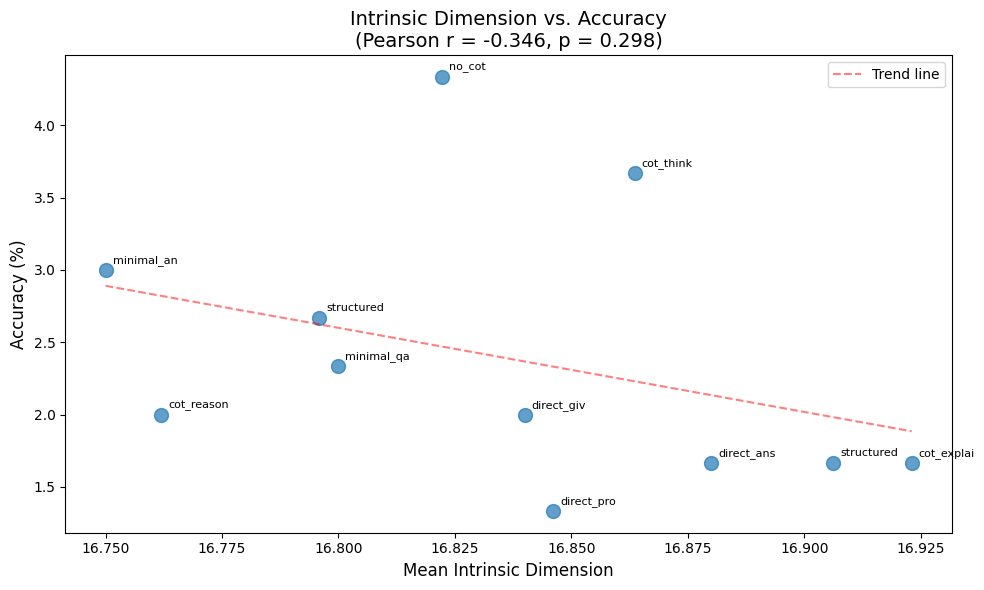

In [19]:
# Figure 1: ID vs Accuracy
plt.figure(figsize=(10, 6))
plt.scatter(df['mean_id'], df['accuracy'] * 100, s=100, alpha=0.7)

for i, row in df.iterrows():
    plt.annotate(row['template_name'][:10],
                (row['mean_id'], row['accuracy'] * 100),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.xlabel('Mean Intrinsic Dimension', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'Intrinsic Dimension vs. Accuracy\n(Pearson r = {r_id:.3f}, p = {p_id:.3f})', fontsize=14)

# Trend line
z = np.polyfit(df['mean_id'], df['accuracy'] * 100, 1)
p = np.poly1d(z)
x_line = np.linspace(df['mean_id'].min(), df['mean_id'].max(), 100)
plt.plot(x_line, p(x_line), "r--", alpha=0.5, label='Trend line')

plt.legend()
plt.tight_layout()
plt.savefig('id_vs_accuracy.png', dpi=150)
plt.show()

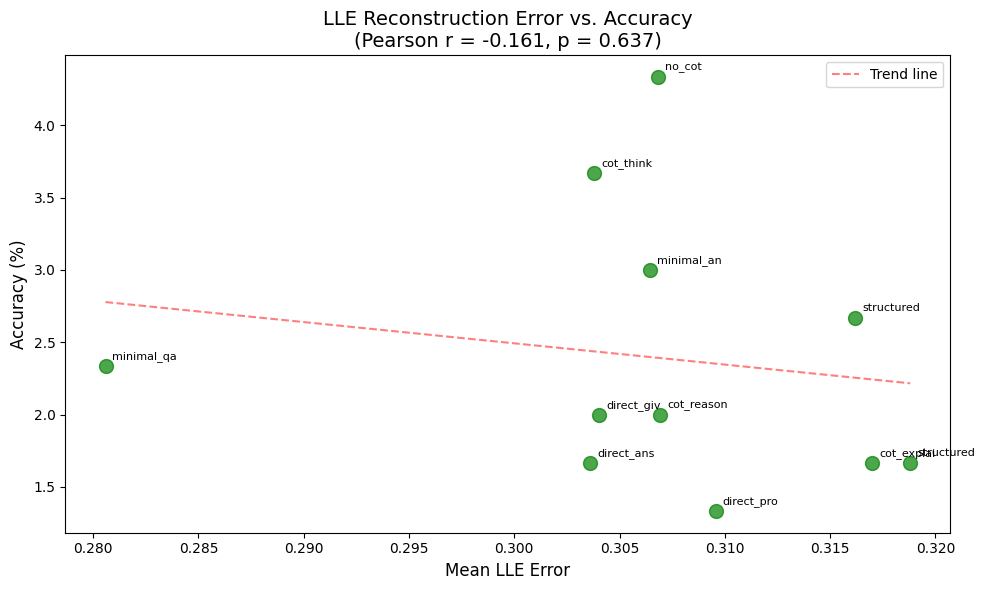

In [20]:
# Figure 2: LLE vs Accuracy
plt.figure(figsize=(10, 6))
plt.scatter(df['mean_lle'], df['accuracy'] * 100, s=100, alpha=0.7, color='green')

for i, row in df.iterrows():
    plt.annotate(row['template_name'][:10],
                (row['mean_lle'], row['accuracy'] * 100),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

plt.xlabel('Mean LLE Error', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title(f'LLE Reconstruction Error vs. Accuracy\n(Pearson r = {r_lle:.3f}, p = {p_lle:.3f})', fontsize=14)

# Trend line
z = np.polyfit(df['mean_lle'], df['accuracy'] * 100, 1)
p = np.poly1d(z)
x_line = np.linspace(df['mean_lle'].min(), df['mean_lle'].max(), 100)
plt.plot(x_line, p(x_line), "r--", alpha=0.5, label='Trend line')

plt.legend()
plt.tight_layout()
plt.savefig('lle_vs_accuracy.png', dpi=150)
plt.show()

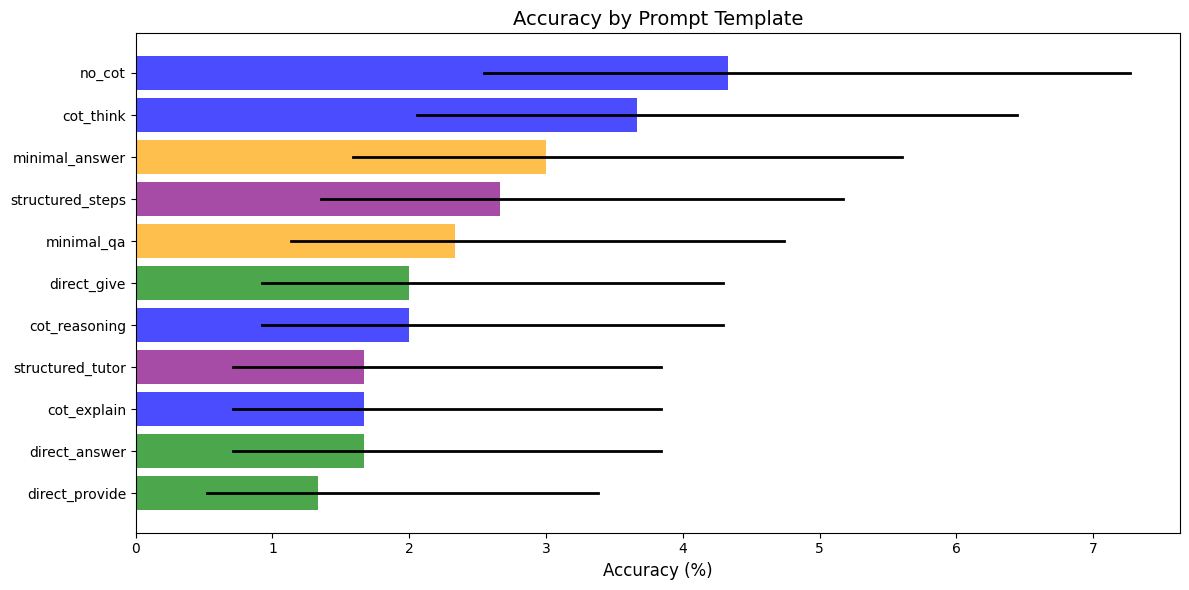

In [21]:
# Figure 3: Bar chart by template
plt.figure(figsize=(12, 6))

df_sorted = df.sort_values('accuracy', ascending=True)

colors = []
for name in df_sorted['template_name']:
    if 'cot' in name.lower():
        colors.append('blue')
    elif 'minimal' in name.lower():
        colors.append('orange')
    elif 'direct' in name.lower():
        colors.append('green')
    elif 'structured' in name.lower():
        colors.append('purple')
    else:
        colors.append('red')

plt.barh(range(len(df_sorted)), df_sorted['accuracy'] * 100, color=colors, alpha=0.7)
plt.yticks(range(len(df_sorted)), df_sorted['template_name'])
plt.xlabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy by Prompt Template', fontsize=14)

# Add CI error bars
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    ci_low = row['ci_low'] * 100
    ci_high = row['ci_high'] * 100
    plt.plot([ci_low, ci_high], [i, i], 'k-', linewidth=2)

plt.tight_layout()
plt.savefig('accuracy_by_template.png', dpi=150)
plt.show()

## 10. Error Analysis

In [22]:
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

error_analysis = []
for template_name, details in all_details.items():
    errors = [d for d in details if not d['correct']]
    extraction_failures = sum(1 for e in errors if e['pred'] is None)
    wrong_answers = len(errors) - extraction_failures

    error_analysis.append({
        "template": template_name,
        "total_errors": len(errors),
        "extraction_failures": extraction_failures,
        "wrong_answers": wrong_answers,
    })

error_df = pd.DataFrame(error_analysis)
print(error_df.to_string())

# Best and worst
best = df.loc[df['accuracy'].idxmax()]
worst = df.loc[df['accuracy'].idxmin()]

print(f"\nBest template: {best['template_name']} ({best['accuracy']:.1%})")
print(f"  Mean ID: {best['mean_id']:.2f}, Mean LLE: {best['mean_lle']:.4f}")

print(f"\nWorst template: {worst['template_name']} ({worst['accuracy']:.1%})")
print(f"  Mean ID: {worst['mean_id']:.2f}, Mean LLE: {worst['mean_lle']:.4f}")

ERROR ANALYSIS
            template  total_errors  extraction_failures  wrong_answers
0         minimal_qa           293                    1            292
1     minimal_answer           291                    0            291
2      direct_answer           295                    7            288
3     direct_provide           296                   16            280
4        direct_give           294                   36            258
5        cot_explain           295                    8            287
6      cot_reasoning           294                   12            282
7          cot_think           289                   14            275
8   structured_tutor           295                    9            286
9   structured_steps           292                    7            285
10            no_cot           287                    3            284

Best template: no_cot (4.3%)
  Mean ID: 16.82, Mean LLE: 0.3068

Worst template: direct_provide (1.3%)
  Mean ID: 16.85, Mean LLE: 0

## 11. Save Results

In [23]:
# Save all results
df.to_csv('results_summary.csv', index=False)
error_df.to_csv('error_analysis.csv', index=False)

with open('correlations.json', 'w') as f:
    json.dump(correlations, f, indent=2)

with open('detailed_results.json', 'w') as f:
    json.dump(all_details, f, indent=2)

print("[*] Results saved:")
print("    - results_summary.csv")
print("    - error_analysis.csv")
print("    - correlations.json")
print("    - detailed_results.json")
print("    - geometry_tables.npz")
print("    - id_vs_accuracy.png")
print("    - lle_vs_accuracy.png")
print("    - accuracy_by_template.png")

[*] Results saved:
    - results_summary.csv
    - error_analysis.csv
    - correlations.json
    - detailed_results.json
    - geometry_tables.npz
    - id_vs_accuracy.png
    - lle_vs_accuracy.png
    - accuracy_by_template.png


In [24]:
# Download results (for Colab)
from google.colab import files

files.download('results_summary.csv')
files.download('correlations.json')
files.download('id_vs_accuracy.png')
files.download('lle_vs_accuracy.png')
files.download('accuracy_by_template.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12. Summary

### Key Findings:

1. **Prompt wording significantly affects accuracy** - Different prompt templates produce different accuracy rates on the same task.

2. **Geometry metrics show patterns** - Mean Intrinsic Dimension (ID) and LLE Error vary across prompt templates.

3. **Correlation analysis** - [Check the correlation values above to see if lower ID/LLE correlates with higher accuracy]

### Interpretation:
- **Lower ID** may indicate tokens in more compact, well-organized embedding neighborhoods
- **Lower LLE** may indicate more stable local linear structure
- If negative correlations are found, this supports the hypothesis that prompts in "cleaner" geometric regions perform better